In [1]:
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy

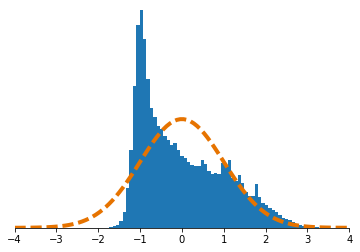

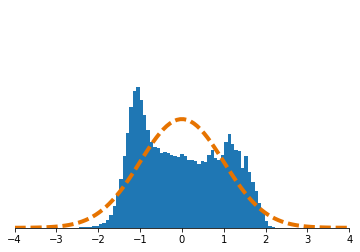

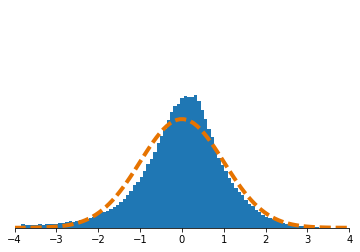

In [159]:
data_dir = '/beegfs/vl1019/BirdVox_datasets/BirdVox-pcen'
wav_names = os.listdir(data_dir)
wav_paths = sorted([os.path.join(data_dir, x) for x in wav_names])
n_files = len(wav_paths)

settings = {
    "fmin": 0,
    "fmax": 10000,
    "hop_length": 1024,
    "n_fft": 2048,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 2048,
    "window": "hann",
    "T": 0.05,#0.395,
    "alpha": 0.98,
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-10}

file_id = 5
wav_path = wav_paths[file_id]
waveform, fs = librosa.load(wav_path, sr=22050)


# Compute Short-Term Fourier Transform (STFT).
stft = librosa.stft(
    waveform,
    n_fft=settings["n_fft"],
    win_length=settings["win_length"],
    hop_length=settings["hop_length"],
    window=settings["window"])

# Compute squared magnitude coefficients.
abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)

# Gather frequency bins according to the Mel scale.
E = librosa.feature.melspectrogram(
    y=None,
    S=abs2_stft,
    sr=settings["sr"],
    n_fft=settings["n_fft"],
    n_mels=settings["n_mels"],
    htk=True,
    fmin=settings["fmin"],
    fmax=settings["fmax"])


PCEN = librosa.pcen(
    S=E,
    time_constant=settings["T"],
    sr=settings["sr"],
    hop_length=settings["hop_length"],
    gain=settings["alpha"],
    power=settings["r"],
    bias=settings["delta"],
    eps=settings["eps"])

E_ravel = E.ravel()
log_E_ravel = np.log(E_ravel)
BC_ravel, lmbda = scipy.stats.boxcox(E_ravel)
BC = scipy.stats.boxcox(E, lmbda=lmbda)
PCEN_ravel = PCEN.ravel()

%matplotlib inline
fig = plt.figure()
xgauss = np.linspace(-4, 4, 100)
hist_x = plt.hist(
    (log_E_ravel - np.mean(log_E_ravel)) / np.std(log_E_ravel), bins=xgauss);

hist_step = np.diff(hist_x[1])[0]
gaussmax = len(E_ravel)/np.sqrt(2*np.pi) * hist_step
ygauss = gaussmax * np.exp(-(xgauss*xgauss)/2)
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, gaussmax*2])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
fig.savefig('logE_histogram.eps', transparent=True, bbox_inches="tight")

fig = plt.figure()
plt.hist((BC_ravel - np.mean(BC_ravel)) / np.std(BC_ravel), bins=xgauss);
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, gaussmax*2])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
fig.savefig('BC_histogram.eps', transparent=True, bbox_inches="tight")

fig = plt.figure(frameon=False)
plt.hist((PCEN_ravel - np.mean(PCEN_ravel)) / np.std(PCEN_ravel), bins=xgauss);
plt.plot(xgauss, ygauss, '--', color="#E67300", linewidth=4.0)
plt.xlim([-4,4])
plt.ylim([0, gaussmax*2])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(labelleft="off", left="off")
fig.savefig('PCEN_histogram.eps', transparent=True, bbox_inches="tight")

# 

In [ ]:
figsize = (10,1.5)
melmin = 65
melmax = 100
tmin = 100

plt.figure(figsize=figsize)
librosa.display.specshow(np.log10(E[melmin:melmax,tmin:]))

plt.figure(figsize=figsize)
librosa.display.specshow(BC[melmin:melmax,tmin:])

plt.figure(figsize=figsize)
librosa.display.specshow(PCEN[melmin:melmax,tmin:])

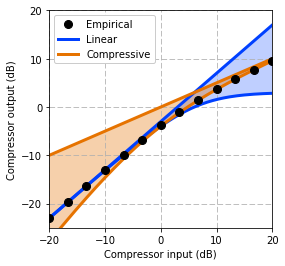

In [196]:
power = 0.5
bias = 1.0

G = np.logspace(-2, 4, 181)
PCEN = (G + bias)**power - bias**power

figsize = (4, 4)

#plt.figure(figsize=figsize)
#plt.plot(M.ravel(), E.ravel(), '.');
#plt.xlim([0.0,0.1])
#plt.ylim([0.0,0.1])

#plt.figure(figsize=figsize)
#plt.plot(M.ravel(), ((E/G).ravel()), '.');
#plt.xlim([0.0,0.09])
#plt.ylim([0.0,0.09])

fig = plt.figure(figsize=figsize)

min_G = 10**(-2.0)
max_G = 10**(+2.0)


legend_linear, = plt.plot(
    10*np.log10(G),
    10*np.log10(G * bias**(power-1) * power),
    color="#0040FF",
    label="Linear",
    linewidth=3.0)

plt.plot(
    10*np.log10(G),
    10*np.log10(np.maximum(1e-10, G * bias**(power-1) * power / (1 + (1-power)/2 * G))),
    color="#0040FF",
    linewidth=3.0)

plt.fill_between(
    10*np.log10(G),
    10*np.log10(G * bias**(power-1) * power),
    10*np.log10(np.maximum(1e-10, G * bias**(power-1) * power / (1 + (1-power)/2 * G))),
    alpha = 0.25,
    color="#0040FF")

legend_compressive, = plt.plot(
    10*np.log10(G),
    10*np.log10(G ** power),
    color="#E67300",
    label="Compressive",
    linewidth=3.0)

plt.plot(
    10*np.log10(G),
    10*np.log10(np.maximum(1e-10, G**power /
                        (1 + bias/G * (power + (G/bias)**(1-power))))),
    color="#E67300",
    linewidth=3.0)

plt.fill_between(
    10*np.log10(G),
    10*np.log10(np.maximum(1e-10, G**power /
                        (1 + bias/G * (power + (G/bias)**(1-power))))),
    10*np.log10(G ** power),
    alpha = 0.33,
    color="#E67300"
)

legend_empirical, = plt.plot(
    10*np.log10(G[::10]),
    10*np.log10(PCEN[::10]),
    'o',
    color='k',
    markersize=8.0,
    label="Empirical");

fig.axes[0].grid(linestyle='--')

leg = plt.legend(
    handles=[legend_empirical, legend_linear, legend_compressive])
leg.get_frame().set_alpha(1)

plt.xlabel("Compressor input (dB)")
plt.ylabel("Compressor output (dB)")

plt.xlim([-20, 20])
plt.xticks([-20, -10, 0, 10, 20])
plt.ylim([-25, 15])
plt.yticks([-20, -10, 0, 10, 20])

fig.savefig('bode_compressor.png',
            transparent=True, bbox_inches="tight", dpi=1000)

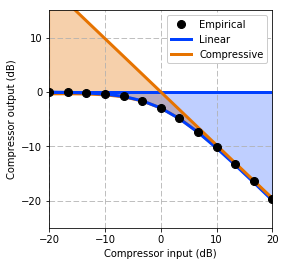

In [195]:
eps = 1.0
M = eps * np.logspace(-2, 2, 13)
denom = (M + eps)**(-gain)

fig = plt.figure(figsize=figsize)

plt.plot(
    10*np.log10(M),
    10*np.log10(np.maximum(1e-10,M**(-gain) / (1 + gain*eps/M))),
    color="#E67300",
    linewidth=3.0)
plt.fill_between(
    10*np.log10(M),
    10*np.log10(M**(-gain)),
    10*np.log10(np.maximum(1e-10,M**(-gain) / (1 + gain*eps/M))),
    alpha = 0.33,
    color="#E67300"
)

plt.plot(
    10*np.log10(M),
    10*np.log10(np.ones(M.size) * eps**(-gain)),
    color="#0040FF",
    linewidth=3.0)
plt.plot(
    10*np.log10(M),
    10*np.log10(np.maximum(1e-10, eps**(-gain) / (1 + gain*M/eps))),
    color="#0040FF",
    linewidth=3.0)
plt.fill_between(
    10*np.log10(M),
    10*np.log10(np.ones(M.size) * eps**(-gain)),
    10*np.log10(np.maximum(1e-10,eps**(-gain) / (1 + gain*M/eps))),
    alpha = 0.25,
    color="#0040FF"
)

plt.plot(
    10*np.log10(M),
    10*np.log10(M**(-gain)),
    color="#E67300",
    linewidth=3.0)
plt.plot(10*np.log10(M), 10*np.log10(denom),
    'o',
    color='k',
    markersize=8.0)


fig.axes[0].grid(linestyle='--')

leg = plt.legend(
    handles=[legend_empirical, legend_linear, legend_compressive])
leg.get_frame().set_alpha(1)

plt.xlabel("Compressor input (dB)")
plt.ylabel("Compressor output (dB)")

plt.xlim([-20, 20])
plt.xticks([-20, -10, 0, 10, 20])
plt.ylim([-25, 15])
plt.yticks([-20, -10, 0, 10])

fig.savefig('bode_renorm.png',
            transparent=True, bbox_inches="tight", dpi=1000)

(0.5, 100000.0)

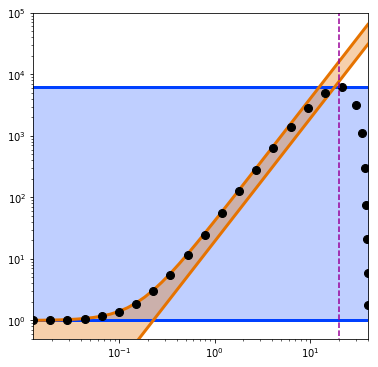

In [595]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

#s = hop_length / (time_constant * sr) 
s = 1 / 40
N = 10000
ω0 = s
ω = np.concatenate(
    (np.logspace(-3.5, 0, 40)[:-2],
     np.array([0.75, 0.81, 0.86, 0.9, 0.93, 0.95, 0.965, 0.975, 0.982, 0.987, 0.991, 0.994, 0.9965, 0.999])))
π = np.pi
α = 1 - ω

#h_diff = ((2/s)/(2**2) + 1/s**2) * (2*π*ω)**2
#h_lf = h_diff + 2
#h_hf = (2/s * np.sin(2*π*ω/2)**2)**2 
#h = (1 + 2/s * np.sin(2*π*ω/2)**2)**2 + (1/s * np.sin(2*π*ω))**2 the form below is simpler
#plt.loglog(ω/ω0, h_diff, '-', color="#E67300", linewidth=3.0)
#plt.loglog(ω/ω0, h_lf, '-', color="#E67300", linewidth=3.0)
#plt.fill_between(
#    ω/ω0, h_diff, h_lf, alpha = 0.33, color="#E67300")
#plt.plot(ω/ω0, np.minimum(h_diff, h_hf), '-', color="#E67300", linewidth=3.0)
#plt.fill_between(
#    ω/ω0, h_hf, h_diff, alpha = 0.33, color="#E67300")


h = (1 + (1-s)**2 - 2 * (1-s) * np.cos(2*π*ω)) / s**2
h_lfinf = 1.0 * np.ones(ω.size)
h_lfsup = (2-s)**2/s**2 * np.ones(ω.size)
h_hfinf = 2*(1-s)/(s**2) * (π*ω)**2
h_hfsup = 1 + 4*(1+s)/(s**2) * (π*ω)**2


plt.figure(figsize=figsize)



plt.loglog(ω/ω0, h_lfsup, '-', color="#0040FF", linewidth=3.0)
plt.loglog(ω/ω0, h_lfinf, '-', color="#0040FF", linewidth=3.0)
plt.fill_between(
    ω/ω0, h_lfinf, h_lfsup, alpha = 0.25, color="#0040FF")

plt.loglog(ω/ω0, h_hfinf, '-', color="#E67300", linewidth=3.0)
plt.loglog(ω/ω0, h_hfsup, '-', color="#E67300", linewidth=3.0)
plt.fill_between(
    ω/ω0, h_hfinf, h_hfsup, alpha = 0.33, color="#E67300")

plt.loglog(ω[::2]/ω0, h[::2], 'o', color='k', markersize=8.0)

plt.plot([0.5/ω0, 0.5 /ω0], [0.1, 1e6], '--', color='#990099')

plt.xlim([np.min(ω/ω0), np.max(ω/ω0)])
plt.ylim([0.5, 1e5])

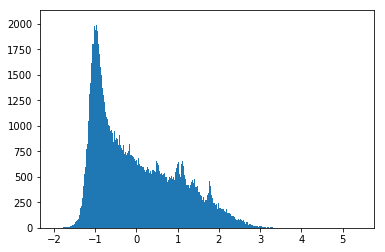

In [121]:
hist_x = plt.hist((log_E_ravel - np.mean(log_E_ravel)) / np.std(log_E_ravel), bins=500);


0.014754969894787084